In [1]:
# Computations
import numpy as np
import pandas as pd
from scipy.stats import norm

# preprocessing
from sklearn.preprocessing import StandardScaler

# sklearn
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Pytorch
import torch
from torch.autograd import Variable
import torch.nn as nn 
import torchvision.transforms as transforms

# Visualisation libraries

## Text
from colorama import Fore, Back, Style
from IPython.display import Image, display, Markdown, Latex

## progress bar
import progressbar

## seaborn
import seaborn as sns
sns.set_context('paper', rc={'font.size':12,'axes.titlesize':14,'axes.labelsize':12})
sns.set_style('white')

## matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Polygon
import matplotlib.gridspec as gridspec
import matplotlib.colors
from pylab import rcParams
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = 14, 8
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
%matplotlib inline

## missingno
import missingno as msno

import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-block alert-info">
<font size="+3"><b>
Telco Customer Churn
</b></font>
</div>


In this article, we analyze and predict customer churn for [Telco Customer Churn data](https://www.kaggle.com/blastchar/telco-customer-churn).

### Dataset

* Customers who left within the last month – the column is called Churn
* Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device * protection, tech support, and streaming TV and movies
* Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
* Demographic info about customers – gender, age range, and if they have partners and dependents

| Columns     | Description     |
|------------------    |---------------------------------------------------------------------------------------------------------------------------------    |
| customerID     | Customer ID     |
| gender     | Whether the customer is a male or a female     |
| SeniorCitizen     | Whether the customer is a senior citizen or not (1, 0)     |
| Partner     | Whether the customer has a partner or not (Yes, No)     |
| Dependents     | Whether the customer has dependents or not (Yes, No)     |
| tenure     | Number of months the customer has stayed with the company     |
| PhoneService     | Whether the customer has a phone service or not (Yes, No)     |
| MultipleLines     | Whether the customer has multiple lines or not (Yes, No, No phone service)     |
| InternetService     | Customer’s internet service provider (DSL, Fiber optic, No)     |
| OnlineSecurity     | Whether the customer has online security or not (Yes, No, No internet service)     |
| OnlineBackup     | Whether the customer has an online backup or not (Yes, No, No internet service)     |
| DeviceProtection     | Whether the customer has device protection or not (Yes, No, No internet service)     |
| TechSupport     | Whether the customer has tech support or not (Yes, No, No internet service)     |
| StreamingTV     | Whether the customer has streaming TV or not (Yes, No, No internet service)     |
| StreamingMovies     | Whether the customer has streaming movies or not (Yes, No, No internet service)     |
| Contract     | The contract term of the customer (Month-to-month, One year, Two years)     |
| PaperlessBilling     | Whether the customer has paperless billing or not (Yes, No)     |
| PaymentMethod     | The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))     |
| MonthlyCharges     | The amount charged to the customer monthly     |
| TotalCharges     | The total amount charged to the customer     |
| Churn     | Whether the customer churned or not (Yes or No)     |

#### Loading the Dataset

In [2]:
Data = pd.read_csv('telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn_clean.csv')

# Modeling

In [3]:
df = Data.drop(columns = ['customer ID'])
Target = 'Churn'
X = df.drop(columns = [Target]).values
y = df[Target].astype(float).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

display(pd.DataFrame(data={'Set':['X_train','X_test','y_train','y_test'],
               'Array Shape':[X_train.shape, X_test.shape, y_train.shape, y_test.shape]}).set_index('Set').T)
Labels = ['Remanined', 'Churned']

Set,X_train,X_test,y_train,y_test
Array Shape,"(4930, 22)","(2113, 22)","(4930,)","(2113,)"


Furthermore, we would like to standardize features by removing the mean and scaling to unit variance. In this [article](https://hatefdastour.github.io/portfolio/statistical_modeling/Pima_Indians_Diabetes_Data_Classification.html), we demonstrated the benefits of scaling data using [**StandardScaler()**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

In [4]:
scaler = StandardScaler()
_ = scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
if torch.cuda.is_available():
    X_train_tensor = Variable(torch.from_numpy(X_train).cuda())
    y_train_tensor = Variable(torch.from_numpy(y_train).type(torch.LongTensor).cuda())
    X_test_tensor = Variable(torch.from_numpy(X_test).cuda())
    y_test_tensor = Variable(torch.from_numpy(y_test).type(torch.LongTensor).cuda())
else:
    X_train_tensor = Variable(torch.from_numpy(X_train))
    y_train_tensor = Variable(torch.from_numpy(y_train).type(torch.LongTensor))
    X_test_tensor = Variable(torch.from_numpy(X_test))
    y_test_tensor = Variable(torch.from_numpy(y_test).type(torch.LongTensor))

In [6]:
Batch_size = 100
iteration_number = 1e4

epochs_number = int(iteration_number / (len(X_train) / Batch_size))

# Pytorch train and test sets
Train_set = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
Test_set = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

# data loader
train_loader = torch.utils.data.DataLoader(Train_set, batch_size = Batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(Train_set, batch_size = Batch_size, shuffle = False)

del X_train_tensor, y_train_tensor, y_test_tensor, Train_set, Test_set

## PyTorch Artificial Neural Network (ANN)

In [this article](https://hatefdastour.github.io/notes/Deel_Learning/Digit_Recognizer_with_Pytorch.html), we talked about **PyTorch ANN**. Here, we would like to create a GPU based model that can classify customer churn efficiently.

In [7]:
# Create ANN Model
class ANNModel(nn.Module):
    def __init__(self, input_Size, hidden_Size, output_Size):
        super(ANNModel, self).__init__()
        # Linear function 1:
        self.fc1 = nn.Linear(input_Size, hidden_Size) 
        # Non-linearity 1
        self.relu1 = nn.ReLU()
        
        # Linear function 2:
        self.fc2 = nn.Linear(hidden_Size, hidden_Size)
        # Non-linearity 2
        self.tanh2 = nn.Tanh()
        
        # Linear function 3:
        self.fc3 = nn.Linear(hidden_Size, hidden_Size)
        # Non-linearity 3
        self.elu3 = nn.ELU()
        
        # Linear function 4:
        self.fc4 = nn.Linear(hidden_Size, output_Size)  
    
    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)
        
        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.tanh2(out)
        
        # Linear function 2
        out = self.fc3(out)
        # Non-linearity 2
        out = self.elu3(out)
        
        # Linear function 4 (readout)
        out = self.fc4(out)
        return out

In [8]:
input_Size, output_Size = len(X[0]), len(np.unique(y))
hidden_Size = 100


# Create ANN
model = ANNModel(input_Size, hidden_Size, output_Size)

# GPU
if torch.cuda.is_available():
    model.cuda()

# Cross Entropy Loss 
CEL= nn.CrossEntropyLoss()

# Optimizer 
learning_rate = 2e-2
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Traning the Model
Count = 0
loss_list = []
Iteration_list = []
Accuracy_list = []
Steps = 50

Progress_Bar = progressbar.ProgressBar(maxval= iteration_number + 200,
                                       widgets=[progressbar.Bar('=', '|', '|'),
                                                progressbar.Percentage()])
# print('---------------------------------------------------------')
for epoch in range(epochs_number):
    for i, (X_train, y_train) in enumerate(train_loader):
        
        # Variables
        X_train = Variable(X_train.view(-1, X[0].shape[0]))
        y_train = Variable(y_train)
        
        # Set all gradients to zero
        optimizer.zero_grad()
        
        # Forward
        Out = model(X_train.float())
        
        # CEL
        loss = CEL(Out, y_train.long())
        
        # Backward (Calculating the gradients)
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        Count += 1
        
        # Predictions
        if Count % Steps == 0:
            # Calculate Accuracy         
            Correct, Total = 0, 0
            # Predictions
            for X_test, y_train in test_loader: 
                X_test = Variable(X_test.view(-1, X[0].shape[0]))
                
                # Forward
                Out = model(X_test.float())
                
                # The maximum value of Out
                Predicted = torch.max(Out.data, 1)[1]
                
                # Total number of y_train
                Total += len(y_train)
                
                # Total Correct predictions
                Correct += (Predicted == y_train).sum()
            
            Accuracy = 100 * (Correct / float(Total))
            
            # store loss and iteration
            loss_list.append(loss.data)
            Iteration_list.append(Count)
            Accuracy_list.append(Accuracy)
            
#         if Count % Steps == 0:
#             # Print Loss
#             print('Iteration: %i,  Loss: %.4f and  Accuracy: %.4f' % (Count, loss.data, Accuracy))

        Progress_Bar.update(Count)

Progress_Bar.finish()

|=========================================================================|100%


Iteration,Loss,Accuracy
50,0.5295079,73.732254
800,0.42137918,79.959435
1550,0.38548782,80.60852
2300,0.3590647,81.17647
3050,0.33700556,81.54158
3800,0.31742638,81.60244
4550,0.30059594,81.84584
5300,0.28652996,81.92698
6050,0.27377468,82.31238
6800,0.25967208,82.31238


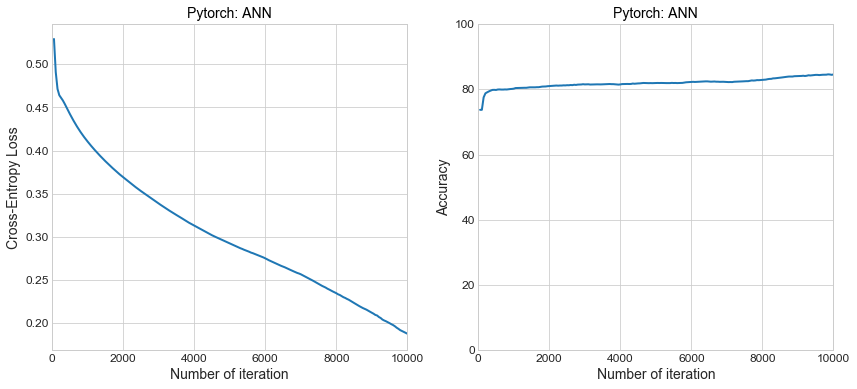

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
_ = ax[0].plot(Iteration_list, loss_list, linewidth=2)
_ = ax[0].set_xlabel("Number of iteration")
_ = ax[0].set_ylabel("Cross-Entropy Loss")
_ = ax[0].set_title("Pytorch: ANN")
_ = ax[0].set_xlim([0,iteration_number])

_ = ax[1].plot(Iteration_list, Accuracy_list, linewidth=2)
_ = ax[1].set_xlabel("Number of iteration")
_ = ax[1].set_ylabel("Accuracy")
_ = ax[1].set_title("Pytorch: ANN")
_ = ax[1].set_xlim([0,iteration_number])
_ = ax[1].set_ylim([0,100])
Table = pd.DataFrame({'Iteration':Iteration_list,
                      'Loss': [x.cpu().numpy() for x in loss_list],
                      'Accuracy': [x.cpu().numpy() for x in Accuracy_list]})
display(Table[0:-1:15].style.hide_index())

A confusion matrix allows the visualization of the performance of a classification model.

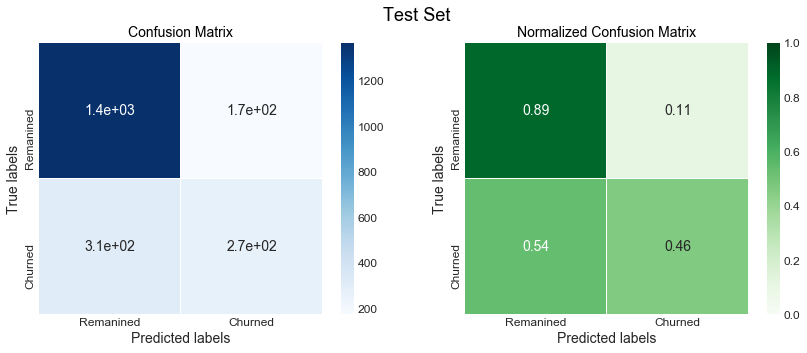

In [10]:
# Test set
y_pred = model(X_test_tensor.float()).cpu().data.numpy()
Confusion_Matrix = confusion_matrix(y_test, y_pred.argmax(axis=1))

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Test Set', fontsize = 18)
_ = sns.heatmap(Confusion_Matrix, annot=True, annot_kws={"size": 14}, cmap="Blues", ax = ax[0],
                linewidths = 0.2, cbar_kws={"shrink": 1})
_ = ax[0].set_xlabel('Predicted labels')
_ = ax[0].set_ylabel('True labels'); 
_ = ax[0].set_title('Confusion Matrix');
_ = ax[0].xaxis.set_ticklabels(Labels)
_ = ax[0].yaxis.set_ticklabels(Labels)

Confusion_Matrix = Confusion_Matrix.astype('float') / Confusion_Matrix.sum(axis=1)[:, np.newaxis]
_ = sns.heatmap(Confusion_Matrix, annot=True, annot_kws={"size": 14}, cmap="Greens", ax = ax[1],
               linewidths = 0.2, vmin=0, vmax=1, cbar_kws={"shrink": 1})
_ = ax[1].set_xlabel('Predicted labels')
_ = ax[1].set_ylabel('True labels'); 
_ = ax[1].set_title('Normalized Confusion Matrix');
_ = ax[1].xaxis.set_ticklabels(Labels)
_ = ax[1].yaxis.set_ticklabels(Labels)

# Predictions

Now for any given dataset, we can predict churn

In [11]:
Sample = df.sample(frac = 0.1)
X_sample = Sample.drop(columns = [Target]).values
X_sample = scaler.transform(X_sample)
if torch.cuda.is_available():
    X_sample_tensor = Variable(torch.from_numpy(X_sample).cuda())
else:
    X_sample_tensor = Variable(torch.from_numpy(X_sample))

y_pred = model(X_sample_tensor.float())
y_pred = np.asarray(y_pred.cpu().detach().numpy())
y_pred = pd.Series(y_pred.argmax(axis=1)).to_frame('Predicted Status').applymap(lambda x: Labels[0] if x ==0 else  Labels[1])

Predictions = pd.concat([Data.loc[Sample.index, 'customer ID'].reset_index(drop = True), y_pred], axis = 1)
display(Predictions)

,customer ID,Predicted Status
0,9250-WYPLL,Churned
1,4931-TRZWN,Remanined
2,9445-SZLCH,Churned
3,8647-SDTWQ,Remanined
4,8270-RKSAP,Remanined
...,...,...
699,1069-QJOEE,Remanined
700,0531-ZZJWQ,Remanined
701,2660-EMUBI,Churned
702,6383-ZTSIW,Remanined


***